In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

# import cortex
import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score

from util import plot, subject
from util.path import Path
from util.atlas import Atlas  # , get_brainmask
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
modelname = "model-gpt2-2b_layer-24"
# modelname = "model-opt-7b_layer-23"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding/trialmot6"
# encmodel = "encoding_trialmot6"
cache = encmodel.split("/")[-1]

modelname, encmodel, cache

('model-gpt2-2b_layer-24', 'encoding/trialmot6', 'trialmot6')

In [4]:
cachedir = f"cache/figure3-mbc/{modelname}/{cache}/"
!mkdir -p $cachedir

In [4]:
mbc_scores = defaultdict(list)
# delayer = SplitDelayer(delays=[2, 3, 4, 5])

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsA = f["cv_preds"][...]  # (5, 6, 240, 81924)
        prod_predA = Y_predsA[:, -2].reshape(1200, -1)
        comp_predA = Y_predsA[:, -1].reshape(1200, -1)
        prodmaskA = f["cv_prodmask"][...].ravel()
    
    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsB = f["cv_preds"][...]  # (5, 6, 240, 81924)
        nuis_predsB = Y_predsB[:, :-2].sum(1).reshape(1200, -1)
        # prod_predB = Y_predsB[:, -2].reshape(1200, -1)
        # comp_predB = Y_predsB[:, -1].reshape(1200, -1)

    # _, switches = subject.get_button_presses(subA)
    # prodmaskA = switches.astype(bool)
    compmaskA = ~prodmaskA
    # prodmaskA = delayer.fit_transform(in_prodA[:, None]).any(-1)
    # compmaskA = delayer.fit_transform(in_compA[:, None]).any(-1)

    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    resB = dataB - nuis_predsB

    for i in range(0, 1200, 240):
        trial_slc = slice(i, i + 240)
        mbc_scores["prod"].append(
            correlation_score( prod_predA[trial_slc][prodmaskA[trial_slc]], resB[trial_slc][prodmaskA[trial_slc]],)
        )
        mbc_scores["comp"].append(
            correlation_score( comp_predA[trial_slc][compmaskA[trial_slc]], resB[trial_slc][compmaskA[trial_slc]],)
        )

    # break

sub_mbc_prod = np.stack(mbc_scores["prod"])
sub_mbc_comp = np.stack(mbc_scores["comp"])
sub_mbc_prod.shape

100%|██████████| 58/58 [29:18<00:00, 30.32s/it]


(290, 81924)

In [10]:
# save
with h5py.File(f"{cachedir}/mbc-between.hdf5", "w") as f:
    f.create_dataset(name="within", data=sub_mbc_prod)
    f.create_dataset(name="between", data=sub_mbc_comp)

In [5]:
# read
with h5py.File(f"{cachedir}/mbc-between.hdf5", "r") as f:
    sub_mbc_prod = f["within"][...]
    sub_mbc_comp = f["between"][...]

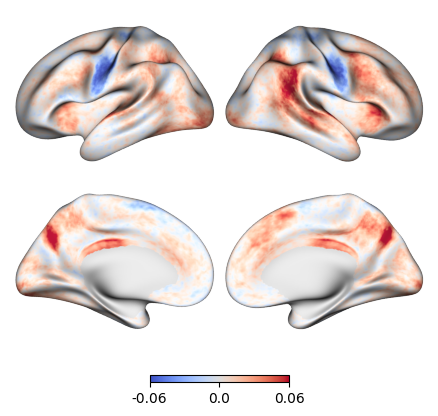

In [6]:
values = (sub_mbc_prod.mean(0) + sub_mbc_comp.mean(0)) / 2
fig = plot.surface_plot(values, cmap="coolwarm")

In [7]:
respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = []
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        results.append(np.mean(f['cv_scores_prod'][:, -2] + f['cv_scores_comp'][:, -1], axis=0))

100%|██████████| 58/58 [00:10<00:00,  5.51it/s]


In [8]:
sub_enc_perf = np.stack(results)
avg_enc_perf = sub_enc_perf.mean(0)
avg_enc_perf.shape

(81924,)

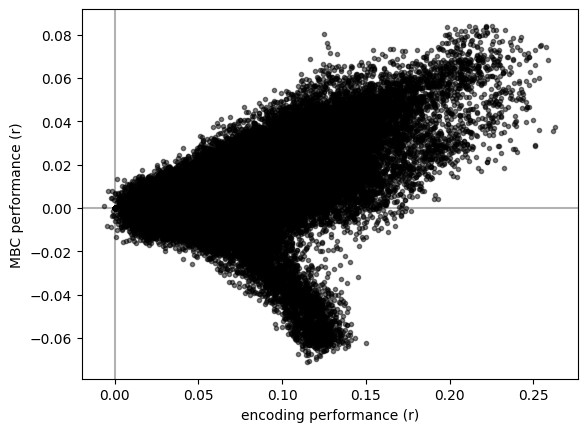

In [9]:
fig, ax = plt.subplots()
ax.scatter(avg_enc_perf, values, marker='.', alpha=0.5, c='k');
ax.axvline(0, c="k", zorder=1, alpha=0.3)
ax.axhline(0, c="k", zorder=1, alpha=0.3)
ax.set_xlabel("encoding performance (r)")
ax.set_ylabel("MBC performance (r)")
fig.show()

In [38]:
from scipy.stats import pearsonr

In [44]:
print(pearsonr(avg_enc_perf, values))
print('abs', pearsonr(avg_enc_perf, np.abs(values)))

PearsonRResult(statistic=0.49820096457253005, pvalue=0.0)
abs PearsonRResult(statistic=0.7158959789210058, pvalue=0.0)


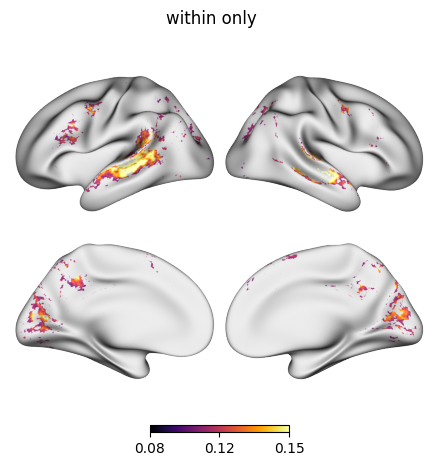

In [27]:
mask = (avg_enc_perf > .1) & (values > .02)
mask = (avg_enc_perf > .1) & (values < -.02)
mask = (avg_enc_perf > .1) & (np.abs(values) < .02)

values2 = avg_enc_perf.copy()
values2[~mask] = 0
fig = plot.surface_plot(values2, cmap="inferno", vmin=0.08, title='within only')
# fig = plot.surface_plot(values2, cmap="inferno", vmin=0.08, title='negative')
# fig = plot.surface_plot(values2, cmap="inferno", vmin=0.08, title='positive')

In [5]:
# read
outdir = f"cache/{modelname}/{cache}/figure-mbc/"
with h5py.File(f"{outdir}/wbc-within-between.hdf5", "r") as f:
    # weight_sim_within = f["within"][...]
    weight_sim_between = f["between"][...]
weight_sim_between.shape

(116, 81924)

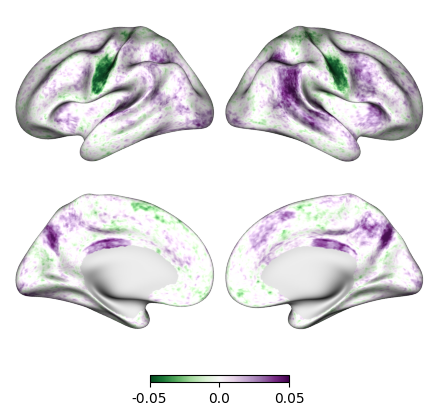

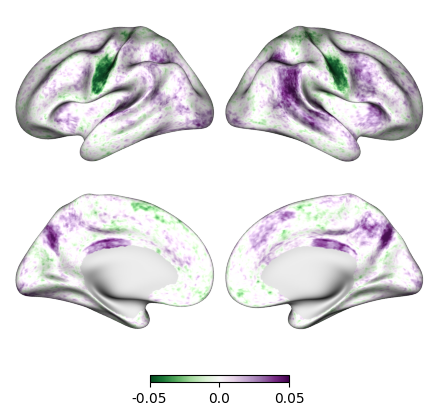

In [10]:
values = weight_sim_between.mean(0)
plot.surface_plot(values, cmap="PRGn_r");